# Continuous Optimization Problem

The following tutorial has the intention to get a first idea how to define a continuous (spatial) problem and to get an idea how optimization algorithms work to solve the particular problem.

#Most important terms

##Problem
An optimization problem is defined as the minimization or maximization of one or several objective functions that can be subject to none, one, or several constraints being used to validate the feasibility of solutions (Chiandussi et al, 2012). Solutions are found by changing the decision variables.

##Decision variable(s)
A decision (or control) variable is a variable that can be changed to alter the solution and thereby the optimality of the modelled problem. It represents the part of the system that can be controlled (e.g. a policy variable).

##Solution
Every solution to a the problem is one (spatial) configuration defined by the value(s) of the decision variable(s).

##Objective(s)
Objectives represent the wishes of the decision maker(s), i.e. what should be maximized or minimized in order to have an 'optimal' solution.

##Objective function(s)
An objective function is the (mathematical) function to compute the objective value on the basis of the solution. That means that the solution is always input to the objective function.

##Constraint(s)
Constraints are set to limit the values the decision variable can take, or are used to filter out solutions that are infeasible (despite having valid decision variable values). 

#Problem: Finding the peak of a mountain

So, in general, optimization algorithms aim to find the maximum or minimum of one objective function, or the multiple maxima/minima of a combination of conflicting objective functions. We start with a simple and easy to picture optimization problem with one objective and two decision variables: a hiker wants to find the top (**maximum**) of the mountain (described by an **objective function**). She starts at the parking lot at the bottom of the mountain and can change her location (x and y coordinate, the **two decision variables**) by walking. She should not wander off the map (**constraints** in possible values of x and y).

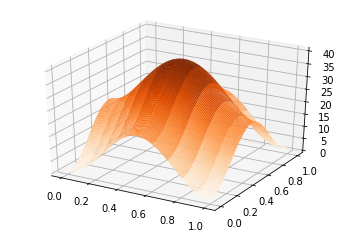

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy
import heapq

# define a map for plotting the mountain and the position of the hiker
# map coordinates range between 0 and 1 for both x and y
X = np.linspace(0, 1, 100)     
Y = np.linspace(0, 1, 100)     
X, Y = np.meshgrid(X, Y) 

# use the rastrigin function to simulate the mountain
Z = (X**2 - 10 * np.cos(2 * np.pi * X)) + \
  (Y**2 - 10 * np.cos(2 * np.pi * Y)) + 20

# create a matplotlib figure and plot the mountain
fig = plt.figure() 
ax = fig.gca(projection='3d') 
ax.plot_surface(X, Y, Z, rstride=1, cstride=10,
  cmap=cm.Oranges, linewidth=0.08,
  antialiased=True)    

plt.show()

In [7]:
#for the position on the mountain with the height we create a class Point
class Point:
  def __init__(self, x,y):
        self.x = x
        self.y = y
        #get the corresponding height from the rastrigin function
        self.z = (self.x**2 - 10 * np.cos(2 * np.pi * self.x)) + (self.y**2 - 10 * np.cos(2 * np.pi * self.y)) + 20
      

In [8]:
#plot function for the 'mountain'
def plot_mountain(fig,X,Y):
  ax = fig.gca(projection='3d') 
  ax.plot_surface(X, Y, Z, rstride=1, cstride=10,
    cmap=cm.Oranges, linewidth=0.08, alpha=0.4, 
    antialiased=True)
  return ax

#plot function for the position of the hiker
def plot_position(ax, p, z_offset=2, color='b', size = 40):
  # set an offset for point to make sure it is visible
  ax.scatter(p.x, p.y, p.z + z_offset, marker='o', s=size, c= color, edgecolors='black',linewidths=0.2)
  return ax

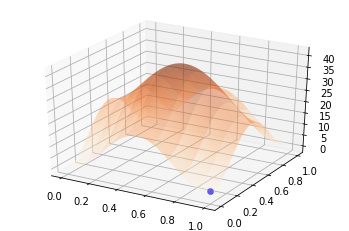

In [9]:
#define a starting point for the hike
p_start = Point(1, 0)

#set up an empty plot
fig = plt.figure()
# produce the mountain plot
ax = plot_mountain(fig,X,Y)
#produce the hike position plot
plot_position(ax, p_start)
#show the plots
plt.show()

#Problem definition
Now, we have a landscape and a starting point of the hike. However, we still need to formulate the problem. Furthermore, the solution needs to be defined and the objective function to quantify the quality of the solution.

In [10]:
class Solution: 
    _id = 0
    
    def __init__(self, representation):
        self._solution_id = Solution._id
        Solution._id += 1
        self.representation = representation

    def verbose(self, print_representation=True):       
        print("Solution ID: %d\nFitness: %.2f\nIs admissible?\tR: %s" %
              (self._solution_id, self.fitness, self.valid))

In [11]:
# The following snippet of code is an example for a very generic problem
class Problem:
    def __init__(self, search_space, objective_function, minimization):
        self.search_space = search_space        
        self.objective_function = objective_function
        self.minimization = minimization
      
    def validate(self, solution):
      pass
    def evaluate(self, solution):
      pass

In [12]:
# Now, we use the same class structure to define our own hiking problem
class ContinuousProblem(Problem):
  
    def __init__(self, search_space, objective_function, minimization=False):
        Problem.__init__(self, search_space, objective_function, minimization)

    def evaluate(self, solution):
        point = solution.representation

        # The validation process determines whether a solution is a feasible solution to the problem. 
        # For this specific hiking problem, we want to ensure that the position always lies within the mountain area.
        solution.valid = self.validate(point)

        if solution.valid:
            solution.fitness = self.objective_function(point)
        else:
            if self.minimization:
                solution.fitness = np.iinfo(np.int32).max
            else:
                solution.fitness = 0

    def validate(self, point):
      validity=True
      # check whether the x position is within the defined mountain region
      if point.x < self.search_space[0][0] or point.x > self.search_space[0][1]:
        validity=False
      # check whether the y position is within the defined mountain region
      if point.y < self.search_space[1][0] or point.y > self.search_space[1][1]:
          validity=False
      return validity


In [13]:
# The objective function to retrieve the objective value of solutions is still missing.
# Here, it is juust the z-value of the position, obtainable from the Point object that is the representation of the solutions.
def get_height(point):
  return point.z

In [14]:
#let's create the problem instance!
mountain_boundary=[[0,1],[0,1]]
hiking_problem = ContinuousProblem(search_space=mountain_boundary, objective_function = get_height)



---


*Poll question: What might be the search space in a real world example?*

---



Now, we can test our problem with an example solution (a point, value for the decision variables x and y). 

Solution ID: 0
Fitness: 31.63
Is admissible?	R: True


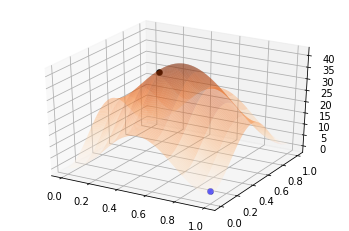

In [15]:
#evaluate an exemplary solution with a position at  x = 0.3 and y = 0.3
test_solution = Solution(representation=Point(0.3,0.6))
hiking_problem.evaluate(test_solution)
test_solution.verbose()

#set up an empty plot
fig = plt.figure()
# produce the mountain plot
ax = plot_mountain(fig,X,Y)
#produce the hike position plot
ax = plot_position(ax, p_start)
ax = plot_position(ax, test_solution.representation, color = 'black' )
#show the plots
plt.show()

Comparable to the general Problem class, we define a Search Algorithm class. 
Many different search algorithm exist, and you will learn about a subset of them.

In [16]:
class SearchAlgorithm:
    def __init__(self, problem_instance):
        self.problem_instance = problem_instance
 
    def initialize(self):
        pass
    
    def search(self, n_iterations, report=False):
        pass

    def get_best(self, candidate_a, candidate_b):
        if self.problem_instance.minimization:
            if candidate_a.fitness >= candidate_b.fitness:
                return candidate_b
            else:
                return candidate_a
        else:
            if candidate_a.fitness <= candidate_b.fitness:
                return candidate_b
            else:
                return candidate_a
    
    # Here, we define reporting functions. They are not a requirement, but convenient.  
    def verbose_reporter(self):
        print("Best solution found:")
        self.best_solution.verbose()

    def verbose_reporter_inner(self, solution, iteration):
        print("> > > Current best solution at iteration %d:" % iteration)
        solution.verbose()



The first algorithm you will learn about is the random search. 
All heuristic search functions contain elements of randomness. In general, the more advanced search algorithms have the goal of outperforming the random search. However, it is a good starting point to learn how a search algorithm works.

In [17]:
def random_neighbor_position(random_state, current_position, max_stepsize):
    
    def positive_or_negative():
      if random_state.random() < 0.5:
          return 1
      else:
          return -1
    
    current_x = current_position.x
    current_y = current_position.y
    random_neighbor_x = current_x + (positive_or_negative() * (random_state.random() * max_stepsize))
    random_neighbor_y = current_y + (positive_or_negative() * (random_state.random() * max_stepsize))
    return Point(random_neighbor_x, random_neighbor_y)

class RandomSearch(SearchAlgorithm):
  def __init__(self, problem_instance, random_state, initial_solution, 
               neighborhood_function = random_neighbor_position, 
               max_stepsize = 0.01):
        SearchAlgorithm.__init__(self, problem_instance)
        self.random_state = random_state
        self.best_solution = initial_solution
        self.neighborhood_function = neighborhood_function
        self.max_stepsize = max_stepsize
        self.problem_instance.evaluate(self.best_solution)
      
  def search(self, n_iterations, report=False):
    all_solutions = []
    i = self.best_solution

    for iteration in range(n_iterations):
      j = self.generate_new_position(i.representation)
      i = self.get_best(i, j)
      all_solutions.append(i)

      if report:
        self.verbose_reporter_inner(i, iteration)

    self.best_solution=i

    return all_solutions

  def generate_new_position(self, current_position):
    random_new_position = self.neighborhood_function(self.random_state, current_position = current_position, 
                                                     max_stepsize = self.max_stepsize)
    random_new_solution = Solution(random_new_position)
    self.problem_instance.evaluate(random_new_solution)
    return random_new_solution

# Random state
In the next step, we define a pseudo random state.

---


*Poll question: What might be the reason to generate a random state with a pseudo-random state generator?*

---

In [18]:
# creates pseudo random numbers generator 
def get_random_state(seed):
    return np.random.RandomState(seed)
# setup random state
seed=1
random_state = get_random_state(seed)

Now, we can create a RandomSearch instance and start the search for optimal solutions

In [19]:
# perform Random Search
start_solution = Solution(p_start)
hiking_problem.evaluate(start_solution)

rs = RandomSearch(hiking_problem, random_state,initial_solution = Solution(p_start))

random_search_solutions = rs.search(n_iterations=400, report=False)
rs.verbose_reporter()

Best solution found:
Solution ID: 381
Fitness: 40.50
Is admissible?	R: True


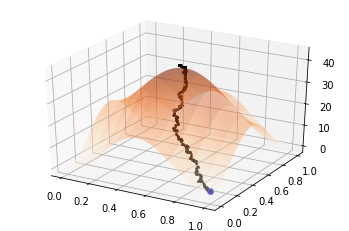

In [20]:
#set up an empty plot
fig = plt.figure()
# produce the mountain plot
ax = plot_mountain(fig,X,Y)
#produce the hike position plot
ax = plot_position(ax, p_start)
for i in range(len(random_search_solutions)):
  ax = plot_position(ax, random_search_solutions[i].representation, color = 'black', size = 5 )
#show the plots
plt.show()

You can run the same search with another random state and compare the results to see how different the final results can be.

# Simulated Annealing


"Annealing procedure defines the optimal molecular arrangements of metal particles where the potential energy of the mass is minimized and refers cooling the metals gradually after subjected to high heat.

 In general manner, SA algorithm adopts an iterative movement according to the variable temperature parameter which imitates the annealing transaction of the metals" (Eren et al. 2017)

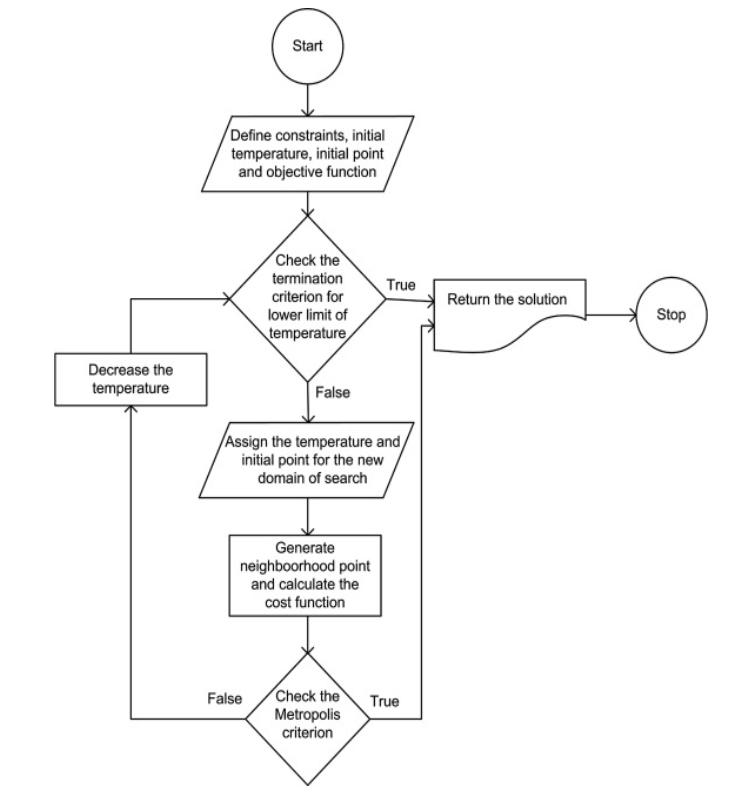

In [21]:
import math

class Annealing(RandomSearch):
  def __init__(self, problem_instance, random_state, initial_solution,
               neighborhood_function = random_neighbor_position, 
               max_stepsize = 0.01, initial_temperature = 1, alpha = 0.01):
    RandomSearch.__init__(self, problem_instance, random_state,initial_solution,
                          neighborhood_function, max_stepsize)
    self.initial_temperature = initial_temperature
    self.alpha = alpha
    
  def search(self, n_iterations, report=False):
    #this is the equivalent to the temperature parameter of simulated annealing
    all_solutions = []
    current_temperature=self.initial_temperature

    i = self.best_solution
    

    for iteration in range(n_iterations):
      j = self.generate_new_position(i.representation)
      i = self.get_p_best(i, j, current_temperature)
      all_solutions.append(i)

      if report:
        self.verbose_reporter_inner(i, iteration)
      
      if current_temperature>=0.01:
        current_temperature -= self.alpha

    self.best_solution=i

    return all_solutions

  def get_p_best(self, candidate_a, candidate_b, actual_c):
    p=0
    if candidate_b.valid:
      if self.problem_instance.minimization:
        # if the new solution is better we accept it
        if candidate_b.fitness <= candidate_a.fitness:
          solution = candidate_b
        #if the new solution is worse we accept it with a certain probability
        elif self.random_state.uniform(0, 1) < (math.exp((candidate_b.fitness - candidate_a.fitness)) / actual_c):
          solution = candidate_b
        else:
          solution = candidate_a
      else:
          # if the new solution is better we accept it
        if candidate_b.fitness >= candidate_a.fitness:
          solution = candidate_b
        #if the new solution is worse we accept it with a certain probability
        elif self.random_state.uniform(0, 1) < (math.exp((candidate_b.fitness - candidate_a.fitness)) / actual_c):
          solution = candidate_b
        else:
          solution = candidate_a
    else:
      solution = candidate_a
    
    return solution
      
  def generate_new_position(self, current_position):
    random_new_position = self.neighborhood_function(self.random_state, current_position = current_position, 
                                                     max_stepsize = self.max_stepsize)
    random_new_solution = Solution(random_new_position)
    self.problem_instance.evaluate(random_new_solution)
    return random_new_solution

In [22]:
random_state = get_random_state(20)
sa = Annealing(problem_instance = hiking_problem, random_state = random_state,
               initial_solution = start_solution, initial_temperature = 50)
#problem_instance, random_state, initial_solution

simulated_annealing_solutions = sa.search(n_iterations=400, report=False)
sa.verbose_reporter()

Best solution found:
Solution ID: 791
Fitness: 40.50
Is admissible?	R: True


#Benchmark

Let's compare the traces of the two algorithms:

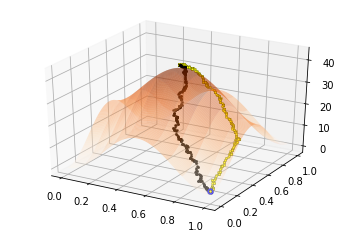

In [23]:
#set up an empty plot
fig = plt.figure()
# produce the mountain plot
ax = plot_mountain(fig,X,Y)
#produce the hike position plot
ax = plot_position(ax, p_start)
for i in range(len(random_search_solutions)):
  ax = plot_position(ax, random_search_solutions[i].representation, color = 'black', size = 5 )
for i in range(len(random_search_solutions)):
  ax = plot_position(ax, simulated_annealing_solutions[i].representation, color = 'yellow', size = 5 )
#show the plots
plt.show()

Fine, but what if we make the problem more difficult?

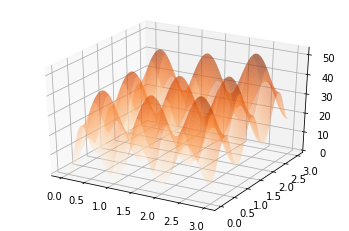

In [24]:
X = np.linspace(0, 3, 100)     
Y = np.linspace(0, 3, 100)     
X, Y = np.meshgrid(X, Y) 

mountain_boundary=[[0,3],[0,3]]
complex_hiking_problem = ContinuousProblem(search_space=mountain_boundary, objective_function = get_height)

#here, we use the rastrigin function to simulate the mountain
Z = (X**2 - 10 * np.cos(2 * np.pi * X)) + \
  (Y**2 - 10 * np.cos(2 * np.pi * Y)) + 20
fig = plt.figure()
# produce the mountain plot
ax = plot_mountain(fig,X,Y)
plt.show()

In [25]:
# perform Random Search
start_solution = Solution(p_start)
complex_hiking_problem.evaluate(start_solution)

rs = RandomSearch(complex_hiking_problem, random_state, max_stepsize= 0.75 ,initial_solution = Solution(p_start))

random_search_solutions = rs.search(n_iterations=2000, report=False)
rs.verbose_reporter()

Best solution found:
Solution ID: 2547
Fitness: 40.49
Is admissible?	R: True


In [26]:
sa = Annealing(problem_instance = complex_hiking_problem,max_stepsize= 0.75 , random_state = random_state,
               initial_solution = start_solution, initial_temperature = 100, alpha = 0.2)

simulated_annealing_solutions = sa.search(n_iterations=2000, report=False)
sa.verbose_reporter()

Best solution found:
Solution ID: 4361
Fitness: 42.47
Is admissible?	R: True


Let's see how the traces from the two algorithms look like this time:

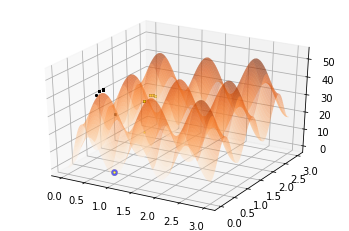

In [27]:
#set up an empty plot
fig = plt.figure()
# produce the mountain plot
ax = plot_mountain(fig,X,Y)
#produce the hike position plot
ax = plot_position(ax, p_start)
for i in range(len(random_search_solutions)):
  ax = plot_position(ax, random_search_solutions[i].representation, color = 'black', size = 5 )
for i in range(len(random_search_solutions)):
  ax = plot_position(ax, simulated_annealing_solutions[i].representation, color = 'yellow', size = 5 )
#show the plots
plt.show()

# Genetic Algorihms


First, we need to define some help functions. Here, we implement the way solutions evolve: How solutions are selected for reproduction, how parent solutions are recombined into offspring solutions, and how they offsprings are mutated.

In [28]:
def select_best_from_parents_and_children(parent_generation, child_generation):
    combined_population = np.hstack((parent_generation, child_generation))
    objective_values_parents = [p.fitness for p in parent_generation]
    objective_values_children = [c.fitness for c in child_generation]
    all_objective_values = np.array(objective_values_parents + objective_values_children)
    # sort by the objective values and get the ids of the better half
    better_half = np.array(heapq.nlargest(parent_generation.shape[0], enumerate(all_objective_values), key=lambda x: x[1]), dtype=np.dtype(np.int32))
    survival_ids = better_half[:,0]
    return combined_population[survival_ids]

def tournament_selection(population, minimization, random_state, selection_pressure = 0.1):
    tournament_pool_size = int(len(population) * selection_pressure)
    tournament_pool = random_state.choice(population, size=tournament_pool_size, replace=False)
    tournament_winner = tournament_pool[0]

    if minimization:
        for solution in tournament_pool:
            if solution.fitness < tournament_winner.rank:
                tournament_winner = solution
    else:
        for solution in tournament_pool:
            if solution.fitness > tournament_winner.fitness:
                tournament_winner = solution
    return tournament_winner

def geometrical_crossover(solution_A, solution_B, random_state):
    point = random_state.uniform(low=0, high=1)
    x_child_A = (solution_A.representation.x * point) + (solution_B.representation.x * (1 - point))
    y_child_A = (solution_A.representation.y * point) + (solution_B.representation.y * (1 - point))

    x_child_B = (solution_A.representation.x * (1 - point)) + (solution_B.representation.x * point)
    y_child_B = (solution_A.representation.y * (1 - point)) + (solution_B.representation.y * point)

    return Solution(Point(x_child_A, y_child_A)), Solution(Point(x_child_B, y_child_B))

def ball_mutation(solution, random_state, max_step_size=0.1, illustrate_mutation = True):
    x = random_state.uniform(low=solution.representation.x - max_step_size,
                             high=solution.representation.x + max_step_size, size=None)
    y = random_state.uniform(low=solution.representation.y - max_step_size,
                             high=solution.representation.y + max_step_size, size=None)
    if illustrate_mutation:
      fig, ax = plt.subplots()
      circle = plt.Circle((solution.representation.x, solution.representation.y), 0.1, zorder=0)
      ax.scatter(x, y,c='r', marker='o', edgecolors='black', linewidths=0.2, zorder=1)
      ax.add_patch(circle)
      ax.set_aspect('equal', 'box')
      plt.show()
    return Solution(Point(x, y))

Next, we extend the RandomSearch class with the Genetic Algorihm.
Question: Why does Genetic Algorithm inherit from a Random Search? How does the evolution in the real world work involve randomness?

In [29]:
class GeneticAlgorithm(RandomSearch):
    def __init__(self, problem_instance, random_state, initial_solution, population_size,
                 selection, crossover, crossover_probability, mutation, mutation_probability, survival):
        RandomSearch.__init__(self, problem_instance, random_state,initial_solution)
        self.population_size = population_size
        self.selection = selection
        self.crossover = crossover
        self.crossover_probability = crossover_probability
        self.mutation = mutation
        self.mutation_probability = mutation_probability
        self.survival = survival
        self.initialize()

    def initialize(self):
        self.population = self.generate_random_valid_chromosomes()
        self.elite = self.get_elite()

    def search(self, n_iterations, max_stepsize, report=False):
        elite_solutions = []

        for iteration in range(n_iterations):
            offsprings = []

            copy_parent_population = deepcopy(self.population)

            while len(offsprings) < len(self.population):
                off1, off2 = p1, p2 = [
                    self.selection(self.population, self.problem_instance.minimization, self.random_state) for _ in range(2)]

                if self.random_state.uniform() < self.crossover_probability:
                    off1, off2 = self.crossover(p1, p2, self.random_state)

                if self.random_state.uniform() < self.mutation_probability:
                    off1 = self.mutation(off1, self.random_state, max_step_size= max_stepsize)
                    off2 = self.mutation(off2, self.random_state, max_step_size= max_stepsize)

                if not hasattr(off1, 'fitness'):
                    self.problem_instance.evaluate(off1)

                if not hasattr(off2, 'fitness'):
                    self.problem_instance.evaluate(off2)

                offsprings.extend([off1, off2])

            while len(offsprings) > len(self.population):
                offsprings.pop()

            #for convenience turn list into numpy array
            offsprings = np.array(offsprings)

            self.population = self.survival(copy_parent_population, offsprings)

            self.elite = self.get_elite()
            elite_solutions.append(self.elite)

            if report:
                self.verbose_reporter_inner(self.elite, iteration)
        return elite_solutions

    def crossover(self, p1, p2):
        off1, off2 = self.crossover(p1, p2, self.random_state)
        off1, off2 = Solution(off1), Solution(off2)
        return off1, off2

    def mutation(self, chromosome):
        mutant = self.mutation(chromosome, self.random_state)
        mutant = Solution(mutant)
        return mutant

    def get_elite(self):
        objective_values = []
        for solution in self.population:
            objective_values.append(solution.fitness)
        objective_values = np.array(objective_values)
        if self.problem_instance.minimization:
            elite_solution = self.population[np.unravel_index(np.argmin(objective_values, axis=None), objective_values.shape)]
        else:
            elite_solution = self.population[np.unravel_index(np.argmax(objective_values, axis=None), objective_values.shape)]
        return elite_solution

    def recombine(self):
        pass

    def phenotypic_diversity_shift(self, offsprings):
        fitness_parents = np.array([parent.fitness for parent in self.population])
        fitness_offsprings = np.array([offspring.fitness for offspring in offsprings])
        return np.std(fitness_offsprings)-np.std(fitness_parents)

    def generate_random_valid_solution(self):
        x_position = self.random_state.uniform(low=self.problem_instance.search_space[0][0],
                                               high=self.problem_instance.search_space[0][1],
                                               size=None)
        y_position = self.random_state.uniform(low=self.problem_instance.search_space[1][0],
                                               high=self.problem_instance.search_space[1][1],
                                               size=None)

        random_new_solution = Solution(Point(x_position, y_position))
        self.problem_instance.evaluate(random_new_solution)
        return random_new_solution

    def generate_random_valid_chromosomes(self):
        chromosomes = np.array([self.generate_random_valid_solution() for _ in range(self.population_size)])
        return chromosomes


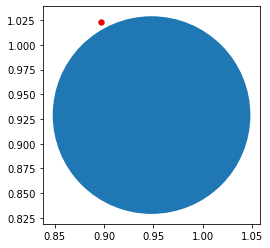

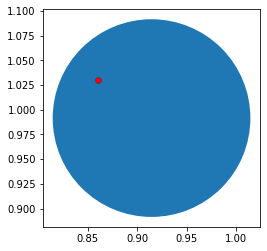

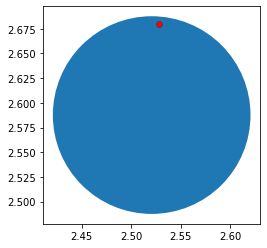

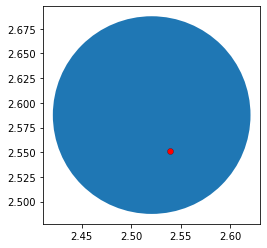

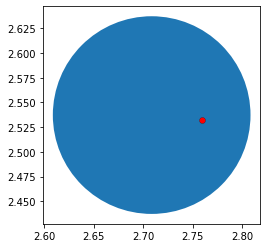

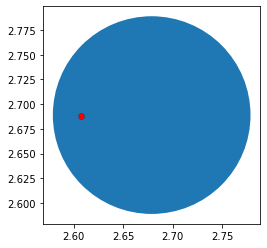

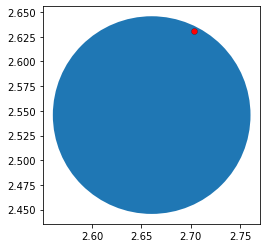

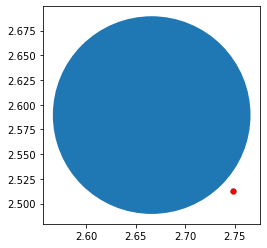

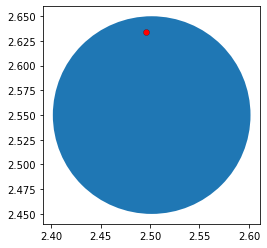

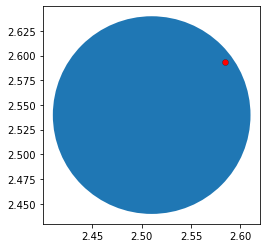

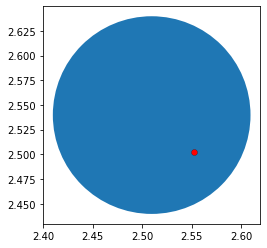

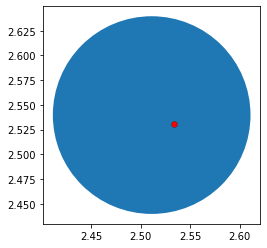

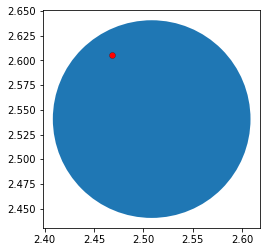

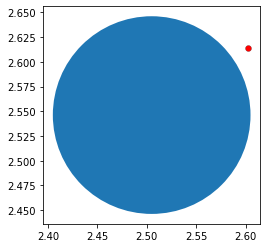

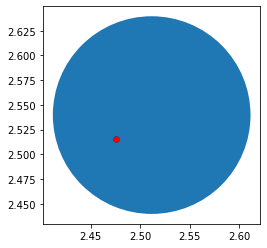

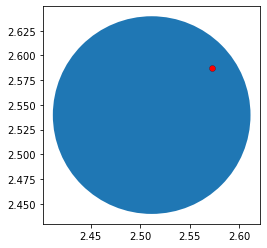

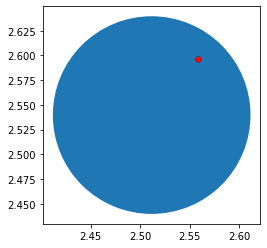

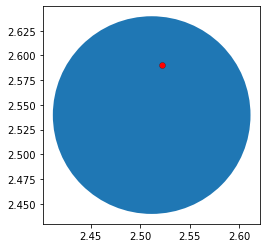

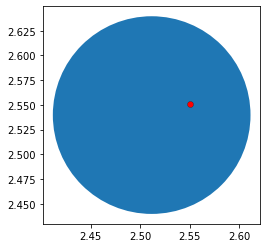

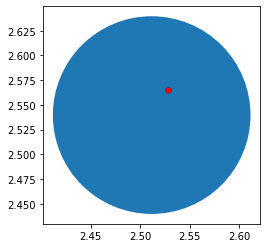

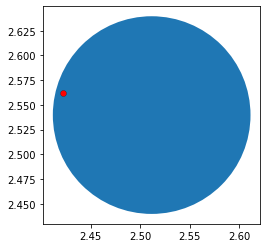

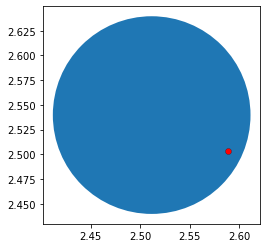

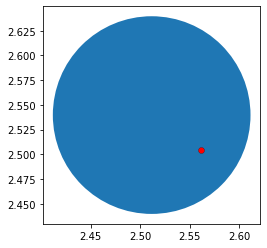

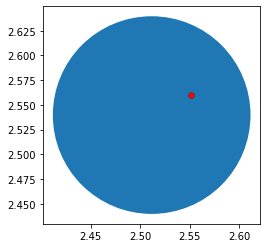

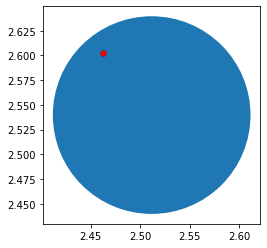

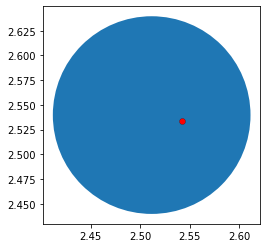

In [30]:
# create the problem instance
mountain_boundary = [[0, 3], [0, 3]]
hiking_problem = ContinuousProblem(search_space=mountain_boundary, objective_function=get_height)

# setup random state
seed = 3
random_state = get_random_state(seed)

p_start = Point(1, 0)
start_solution = Solution(p_start)
hiking_problem.evaluate(start_solution)

#create a Genetic Algorithm instance
ga = GeneticAlgorithm(problem_instance=hiking_problem,
                          random_state=random_state,
                          initial_solution=start_solution,
                          population_size = 20,
                          selection = tournament_selection,
                          crossover = geometrical_crossover,
                          crossover_probability = 0.8,
                          mutation = ball_mutation,
                          mutation_probability = 0.1,
                          survival = select_best_from_parents_and_children
                          )


max_stepsize_for_ballmutation = 0.1
#optimize!
ga_solutions = ga.search(n_iterations = 20, max_stepsize = max_stepsize_for_ballmutation)

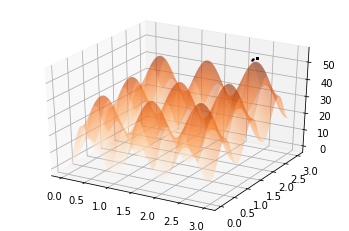

In [31]:
fig = plt.figure()
ax = plot_mountain(fig, X, Y)
for i in range(len(ga_solutions)):
    ax = plot_position(ax, ga_solutions[i].representation, color='black', size=5)
# show the plots
plt.show()